In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from skopt import BayesSearchCV
import sys
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE

# Defining train_model function

In [2]:

def train_model(X, y):
    base_model = DecisionTreeClassifier(random_state=42)
    adaboost_model = AdaBoostClassifier(base_model, random_state=42)
    model2 = RandomForestClassifier(random_state=42)
    model = VotingClassifier(estimators=[('adaboost', adaboost_model), ('random_forest', model2)], voting='soft')
    
    param_grid = {
    'random_forest__n_estimators': [100, 1000, 2000],
    'random_forest__max_depth': [None, 10, 20, 30, 40, 50, 60],
    'random_forest__max_features': [None, 'sqrt', 'log2', 0.5],
    'random_forest__min_samples_split': [2, 5, 10, 20, 40],
    'random_forest__min_samples_leaf': [1, 2, 4, 8, 16],
    'random_forest__bootstrap': [True, False],
    'adaboost__n_estimators': [100, 1000, 2000],
    'adaboost__learning_rate': [0.1, 0.5, 1.0]
    }
    metrics_dict = {
        'test_accuracy': [],
        'test_precision': [],
        'test_recall': [],
        'test_roc_auc': [],
        'test_f1': [],
        'train_accuracy': [],
        'train_precision': [],
        'train_recall': [],
        'train_roc_auc': [],
        'train_f1': []
    }
    
    cv_results = []
    best_models = []
    best_indices = []
    
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_index, test_index in outer_cv.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        inner_cv = KFold(n_splits=10, shuffle=True, random_state=42)
        
        bayes_search = BayesSearchCV(
            estimator=model,
            search_spaces=param_grid,
            n_iter=20,  # Number of iterations for optimization
            cv=inner_cv,
            scoring='accuracy',
            n_jobs=5,
            random_state=42
        )
        
        bayes_search.fit(X_train, y_train)
        best_model = bayes_search.best_estimator_
        best_model.fit(X_train, y_train)
        
        predictions = best_model.predict(X_test)
        predictions_train = best_model.predict(X_train)
        predictions_2 = best_model.predict_proba(X_test)
        predictions_2_train = best_model.predict_proba(X_train)
        
        test_accuracy = accuracy_score(y_test, predictions)
        test_precision = precision_score(y_test, predictions, average='macro')
        test_recall = recall_score(y_test, predictions, average='macro')
        test_roc_auc = roc_auc_score(y_test, predictions_2,  multi_class='ovr')
        test_f1 = f1_score(y_test, predictions, average='macro')
        
        train_accuracy = accuracy_score(y_train, predictions_train)
        train_precision = precision_score(y_train, predictions_train, average='macro')
        train_recall = recall_score(y_train, predictions_train, average='macro')
        train_roc_auc = roc_auc_score(y_train, predictions_2_train,  multi_class='ovr')
        train_f1 = f1_score(y_train, predictions_train, average='macro')
        
        metrics_dict['test_accuracy'].append(test_accuracy)
        metrics_dict['test_precision'].append(test_precision)
        metrics_dict['test_recall'].append(test_recall)
        metrics_dict['test_roc_auc'].append(test_roc_auc)
        metrics_dict['test_f1'].append(test_f1)
        metrics_dict['train_accuracy'].append(train_accuracy)
        metrics_dict['train_precision'].append(train_precision)
        metrics_dict['train_recall'].append(train_recall)
        metrics_dict['train_roc_auc'].append(train_roc_auc)
        metrics_dict['train_f1'].append(train_f1)
        
        cv_results.append(bayes_search.cv_results_)
        best_models.append(best_model)
        best_indices.append(bayes_search.best_index_)
    
    # Averaging the metrics over the outer folds
    avg_metrics = {k: np.mean(v) for k, v in metrics_dict.items()}
    
    best_model_index = np.argmax(metrics_dict['test_accuracy'])
    best_model_overall = best_models[best_model_index]
    
    return avg_metrics, best_model_overall, y_test, X_test, metrics_dict, predictions_2

# Main code

In [3]:
# Read dataset
df = pd.read_csv(r'output_combined.csv')
# Prep the dataset
df = df.dropna()
df = df.drop(df.columns[df.columns.str.contains('Unnamed')], axis=1)
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.dayofyear
df = df.drop(df.index[-1])
replacement_dict = {'Non': 0, 'NPF': 1, 'undefined': 2}
df['day.type'] = df['day.type'].replace(replacement_dict)
df_orig = df

# SMOTE

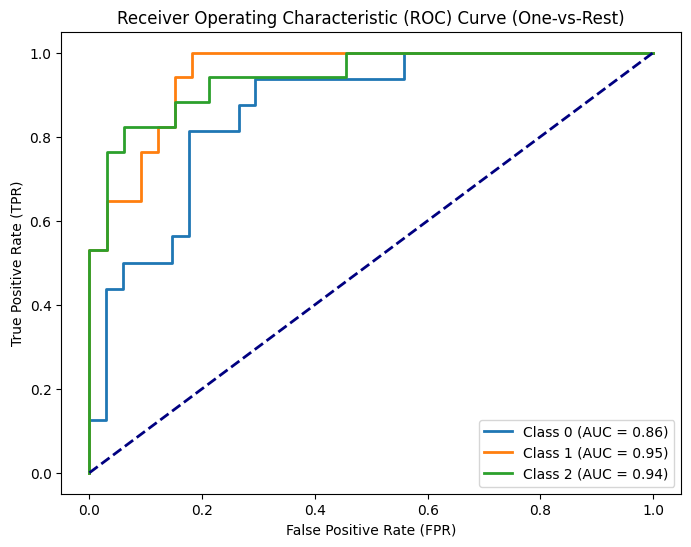

In [4]:

df_selected = df_orig[["pressure", "RH", "temperature", "SRAD", "day.type"]].copy()
df = df_selected
# Split dataset
X = df.drop(columns=["day.type"])
y = df["day.type"]

smote = SMOTE(sampling_strategy='auto')
X, y = smote.fit_resample(X, y)

# Unpack results
avg_metrics, model, y_test, X_test, metrics_dict, predictions_2 = train_model(X=X, y=y)

# Redirect stdout to a file
with open('rf_adb_tuned_smote.txt', 'w') as file:
    sys.stdout = file
    print("Test accuracy", avg_metrics['test_accuracy'])
    print("Test precision", avg_metrics['test_precision'])
    print("Test recall", avg_metrics['test_recall'])
    print("Test roc_auc", avg_metrics['test_roc_auc'])
    print("Test f1", avg_metrics['test_f1'])
    print('-------------------------------------------------------------------------------')
    print("Train accuracy", avg_metrics['train_accuracy'])
    print("Train precision", avg_metrics['train_precision'])
    print("Train recall", avg_metrics['train_recall'])
    print("Train roc_auc", avg_metrics['train_roc_auc'])
    print("Train f1", avg_metrics['train_f1'])
    print('-------------------------------------------------------------------------------')
    for i in range(len(metrics_dict['test_accuracy'])):
        print(f"Fold {i+1} - Test Accuracy: {metrics_dict['test_accuracy'][i]:.4f}, Test Precision: {metrics_dict['test_precision'][i]:.4f}, Test Recall: {metrics_dict['test_recall'][i]:.4f}")
    print('-------------------------------------------------------------------------------')
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test to one-hot encoding
y_test_onehot = pd.get_dummies(y_test)
# Calculate ROC curve for each class
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot.iloc[:, i], predictions_2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
# plt.show()
plt.savefig('rf_adb_tuned_ROC_smote.png', dpi=300)

# NORM

c:\Users\Masloriy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


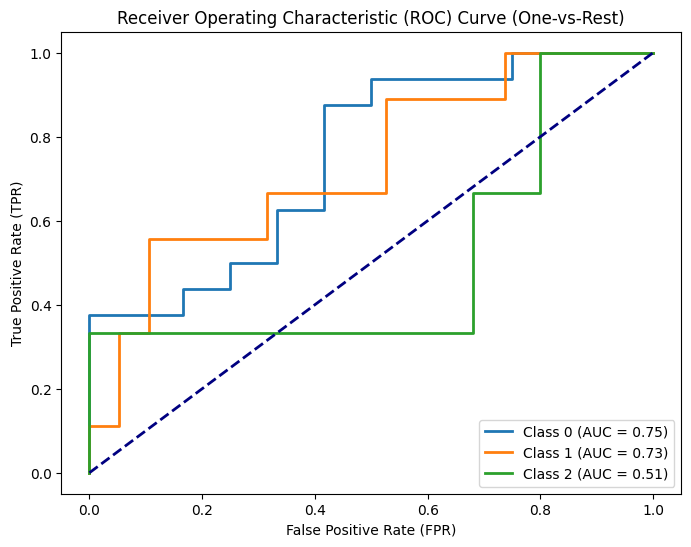

In [5]:

df_selected = df_orig[["pressure", "RH", "temperature", "SRAD", "day.type"]].copy()
df = df_selected
# Split dataset
X = df.drop(columns=["day.type"])
y = df["day.type"]

# Unpack results
avg_metrics, model, y_test, X_test, metrics_dict, predictions_2 = train_model(X=X, y=y)

# Redirect stdout to a file
with open('rf_adb_tuned_norm.txt', 'w') as file:
    sys.stdout = file
    print("Test accuracy", avg_metrics['test_accuracy'])
    print("Test precision", avg_metrics['test_precision'])
    print("Test recall", avg_metrics['test_recall'])
    print("Test roc_auc", avg_metrics['test_roc_auc'])
    print("Test f1", avg_metrics['test_f1'])
    print('-------------------------------------------------------------------------------')
    print("Train accuracy", avg_metrics['train_accuracy'])
    print("Train precision", avg_metrics['train_precision'])
    print("Train recall", avg_metrics['train_recall'])
    print("Train roc_auc", avg_metrics['train_roc_auc'])
    print("Train f1", avg_metrics['train_f1'])
    print('-------------------------------------------------------------------------------')
    for i in range(len(metrics_dict['test_accuracy'])):
        print(f"Fold {i+1} - Test Accuracy: {metrics_dict['test_accuracy'][i]:.4f}, Test Precision: {metrics_dict['test_precision'][i]:.4f}, Test Recall: {metrics_dict['test_recall'][i]:.4f}")
    print('-------------------------------------------------------------------------------')
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test to one-hot encoding
y_test_onehot = pd.get_dummies(y_test)
# Calculate ROC curve for each class
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot.iloc[:, i], predictions_2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
# plt.show()
plt.savefig('rf_adb_tuned_ROC_norm.png', dpi=300)

# PM25 AND SO2

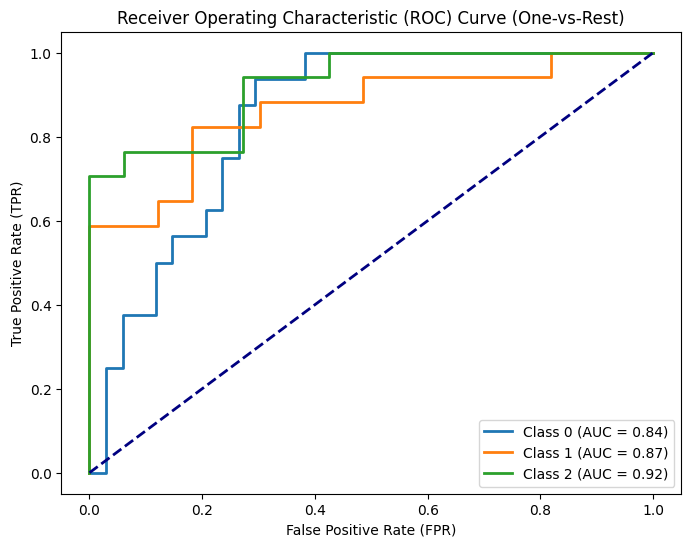

In [6]:

df_selected = df_orig[["pressure", "RH", "temperature", "SRAD", "day.type", 'pm25', 'so2']].copy()
df = df_selected
# Split dataset
X = df.drop(columns=["day.type"])
y = df["day.type"]

smote = SMOTE(sampling_strategy='auto')
X, y = smote.fit_resample(X, y)

# Unpack results
avg_metrics, model, y_test, X_test, metrics_dict, predictions_2 = train_model(X=X, y=y)
# Redirect stdout to a file
with open('rf_adb_tuned_smote_all.txt', 'w') as file:
    sys.stdout = file
    print("Test accuracy", avg_metrics['test_accuracy'])
    print("Test precision", avg_metrics['test_precision'])
    print("Test recall", avg_metrics['test_recall'])
    print("Test roc_auc", avg_metrics['test_roc_auc'])
    print("Test f1", avg_metrics['test_f1'])
    print('-------------------------------------------------------------------------------')
    print("Train accuracy", avg_metrics['train_accuracy'])
    print("Train precision", avg_metrics['train_precision'])
    print("Train recall", avg_metrics['train_recall'])
    print("Train roc_auc", avg_metrics['train_roc_auc'])
    print("Train f1", avg_metrics['train_f1'])
    print('-------------------------------------------------------------------------------')
    for i in range(len(metrics_dict['test_accuracy'])):
        print(f"Fold {i+1} - Test Accuracy: {metrics_dict['test_accuracy'][i]:.4f}, Test Precision: {metrics_dict['test_precision'][i]:.4f}, Test Recall: {metrics_dict['test_recall'][i]:.4f}")
    print('-------------------------------------------------------------------------------')
    # Reset stdout back to the console
    sys.stdout = sys.__stdout__

# Calculate ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test to one-hot encoding
y_test_onehot = pd.get_dummies(y_test)
# Calculate ROC curve for each class
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot.iloc[:, i], predictions_2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {model.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (One-vs-Rest)')
plt.legend(loc='lower right')
# plt.show()
plt.savefig('rf_adb_tuned_ROC_smote_all.png', dpi=300)